# Manipulation de la librairie networkx

## Construction de réseaux d'interactions à partir de données MITAB.

Le format (MITAB) stocke des paires de protéines en interaction. Dans ce format, chaque colonne porte une information spécifique.
Une description du format est disponible [ici](https://psicquic.github.io/MITAB27Format.html).
Les données d'interactions impliquant les protéines surreprésentées de l'expérience ont été obtenues depuis la base de données [Intact](https://www.ebi.ac.uk/intact/home).
Ces données sont mises à votre disposition dans le fichier `data/proteins.mitab`.

Vous extrairez du fichier les paires d'identifiants uniprot des protéines en interaction.

Ces paires de protéines constituent un réseau d'interaction protéine-protéine que vous allez dessiner à l'aide de la libraire [networkx](https://networkx.org/documentation/stable/reference).
Le code suivant vous est fourni à titre d'exemple.

```python
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()

fig, ax = plt.subplots(figsize=(8, 8))

G.add_edge('a', 'b')
G.add_edge('e', 'b')
G.add_edge('e', 'a')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['blue','blue','red'] , node_size=2000)
```


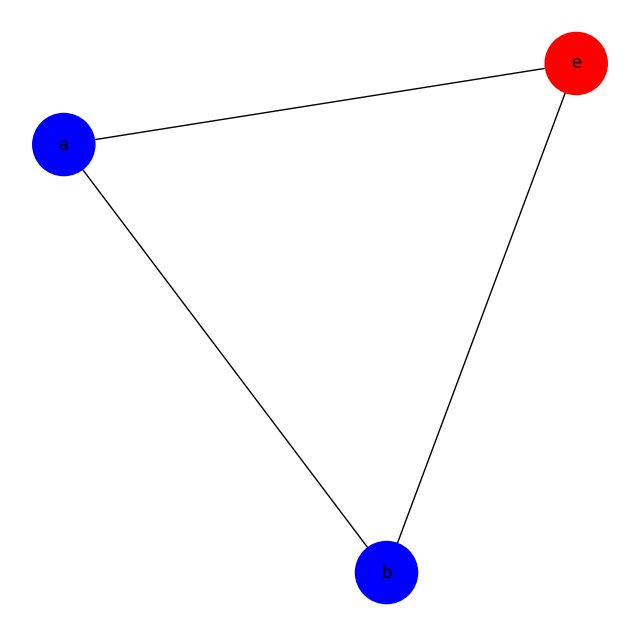

In [20]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import numpy as np
from stat_utils import GO_ORA_analyser
import sys, os

import matplotlib.colors as colors
import matplotlib.cm as cmx



G = nx.Graph()

fig, ax = plt.subplots(figsize=(8, 8))

G.add_edge('a', 'b')
G.add_edge('e', 'b')
G.add_edge('e', 'a')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=['blue','blue','red'] , node_size=2000)

In [2]:
mitab_data = pandas.read_csv('../data/proteins.mitab', sep='\t',header=None)

In [3]:
mitab_data[1]

0      uniprotkb:P02358
1      uniprotkb:P0AFG8
2      uniprotkb:P02358
3      uniprotkb:P62399
4      uniprotkb:P0ACF8
             ...       
385    uniprotkb:P0ACF8
386    uniprotkb:P76344
387    uniprotkb:P62399
388    uniprotkb:P62399
389    uniprotkb:P0ACF8
Name: 1, Length: 390, dtype: object

In [4]:
data=[[],[],[]]
for i in range(len(mitab_data[0])):
    elem1=mitab_data[0][i]
    elem2=mitab_data[1][i]
    if ('uniprot' in elem1) and ('uniprot' in elem2):
        data[0].append(elem1[10:])
        data[1].append(elem2[10:])
        data[2].append('physical association' in mitab_data[11][i])

NameError: name 'f' is not defined

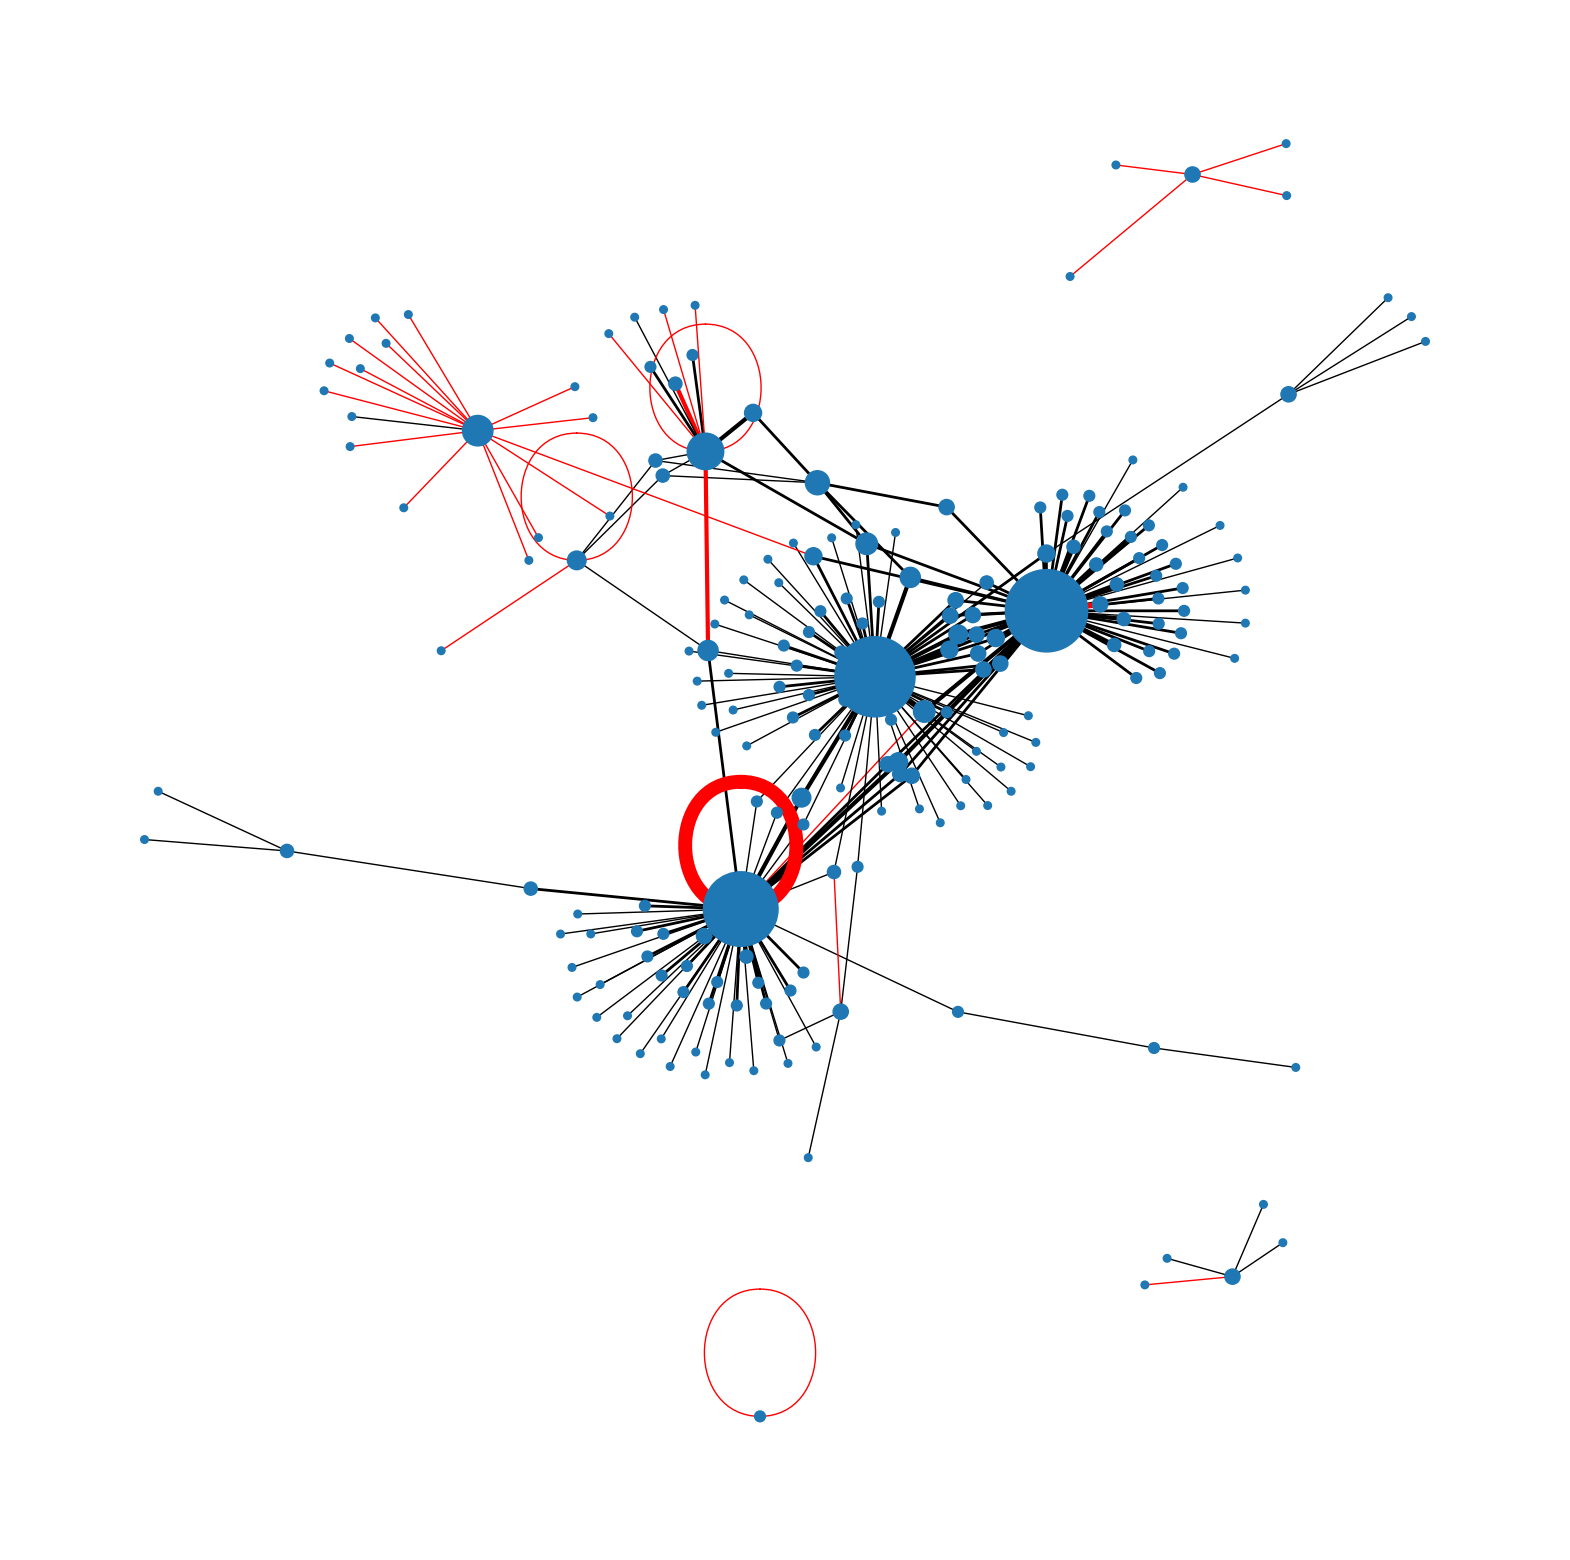

In [16]:
G = nx.Graph()

fig, ax = plt.subplots(figsize=(20, 20))
dict_part = {}
for i in range(len(data[0])):
    prot1 = data[0][i]
    prot2 = data[1][i]
    phys = data[2][i]
    if not prot1 in dict_part.keys():
        dict_part[prot1]={}
    if not prot2 in dict_part.keys():
        dict_part[data[1][i]]={}
    if not prot2 in dict_part[prot1].keys():
        dict_part[prot1][prot2]=1
    else:
        dict_part[prot1][prot2]+=1
    if not prot1 in dict_part[prot2].keys():
        dict_part[prot2][prot1]=1
    else:
        dict_part[prot2][prot1]+=1
        
    if G.has_edge(prot1, prot2):
        G[prot1][prot2]['weight']+=1
    else:
        G.add_edge(prot1, prot2, weight=1, color='black')
    if phys:
        G[prot1][prot2]['color']='red'
list_size=[]
for cle in dict_part.keys():
    list_size.append(sum(dict_part[cle].values())*30)
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]    

pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=False, node_size=list_size, width=weights, edge_color=colors)


Les positions des noeuds sont paramétrables au travers de l'objet [layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html). Une fois une première représentation du réseau obtenue, affinez celle-ci afin de:

* Écrire les identifiants uniprot dans les noeuds du réseau.
* Faire du diamètre des noeuds une fonction du nombre de partenaires protéiques.
* Faire de la largeur des arêtes une fonction du nombre d'experiences (lignes MITAB) detectant cette interaction
* Colorier les arêtes soutenues par au moins une interaction de type physique entre proteines.


## Croisement des données d'interaction et de protéomique

En utilisant les données d'abondance du fichier `TCL_wt1.tsv`, essayez de modifier le rendu du réseau pour:
* colorier dans une couleur spécifique uniquement les protéines surabondantes dans l'expérience.
* N'afficher que les noeuds des protéines mesurées dans l'experience.
* Utiliser une échelle de couleur continue fonction de l'abondance pour colorier les noeuds.
* colorier les protéines appartenant à des classes GO communes.

In [6]:
data_TCL = pandas.read_csv('../TCL_wt1.tsv',sep='\t', na_values='#VALEUR!',
                dtype = {'Accession':str, 'Corrected Abundance ratio (1.53)':float})
dn=data_TCL.dropna()

names = dn.columns.tolist()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# class Colorizer:
#     def _init__(self, dfpanda):
#         self.dfpanda = dfpanda
#         self.dfiltered = self.dfpanda.loc[self.dfpanda[self.dfpanda.columns[4]]>-0.0977520223573736][[names[index]for index in [0,4,6]]]
#         self.liste_name = self.dfiltered['Accession'].tolist()
#         self.liste_abund = self.dfiltered['Log2 Corrected Abundance Ratio'].tolist()
    
#     def byAbundance(nodeList):
        
        
        
        
d_filtered=dn.loc[dn[dn.columns[4]]>-0.0977520223573736][[names[index]for index in [0,4,6]]]
liste_name = dn['Accession'].tolist()
liste_abund = dn['Log2 Corrected Abundance Ratio'].tolist()


In [7]:
for elem in d_filtered['Log2 Corrected Abundance Ratio']:
    print(elem)
len(G.edges)

-0.092480916
-0.089467977
-0.085460488
-0.083460911
-0.07449695
-0.070530776
-0.065588342
-0.061646549
-0.060662782
-0.051838932
-0.049885383
-0.038219322
-0.035317487
-0.035317487
-0.033386168
-0.030494029
-0.025686644
-0.020895224
-0.013261899
-0.012310567
-0.006615711
-0.000943246
0.0
0.015008666
0.018736563
0.029862801
0.029862801
0.034473527
0.034473527
0.042735882
0.050040682
0.056402183
0.059119976
0.064540252
0.070838276
0.073529035
0.106308902
0.10718459
0.108934372
0.11417102
0.11504195
0.129767875
0.131490496
0.168037892
0.180572246
0.18140401
0.187212971
0.231255697
0.236867744
0.279442162
0.299501347
0.327574658
0.335069195
0.360263277
0.371239959
0.372697227
0.417157551
0.431911318
0.461658661
0.551254625
0.588102208
0.604939558
0.619129104
0.634395861
0.65968582
0.811390435
0.846424487


238

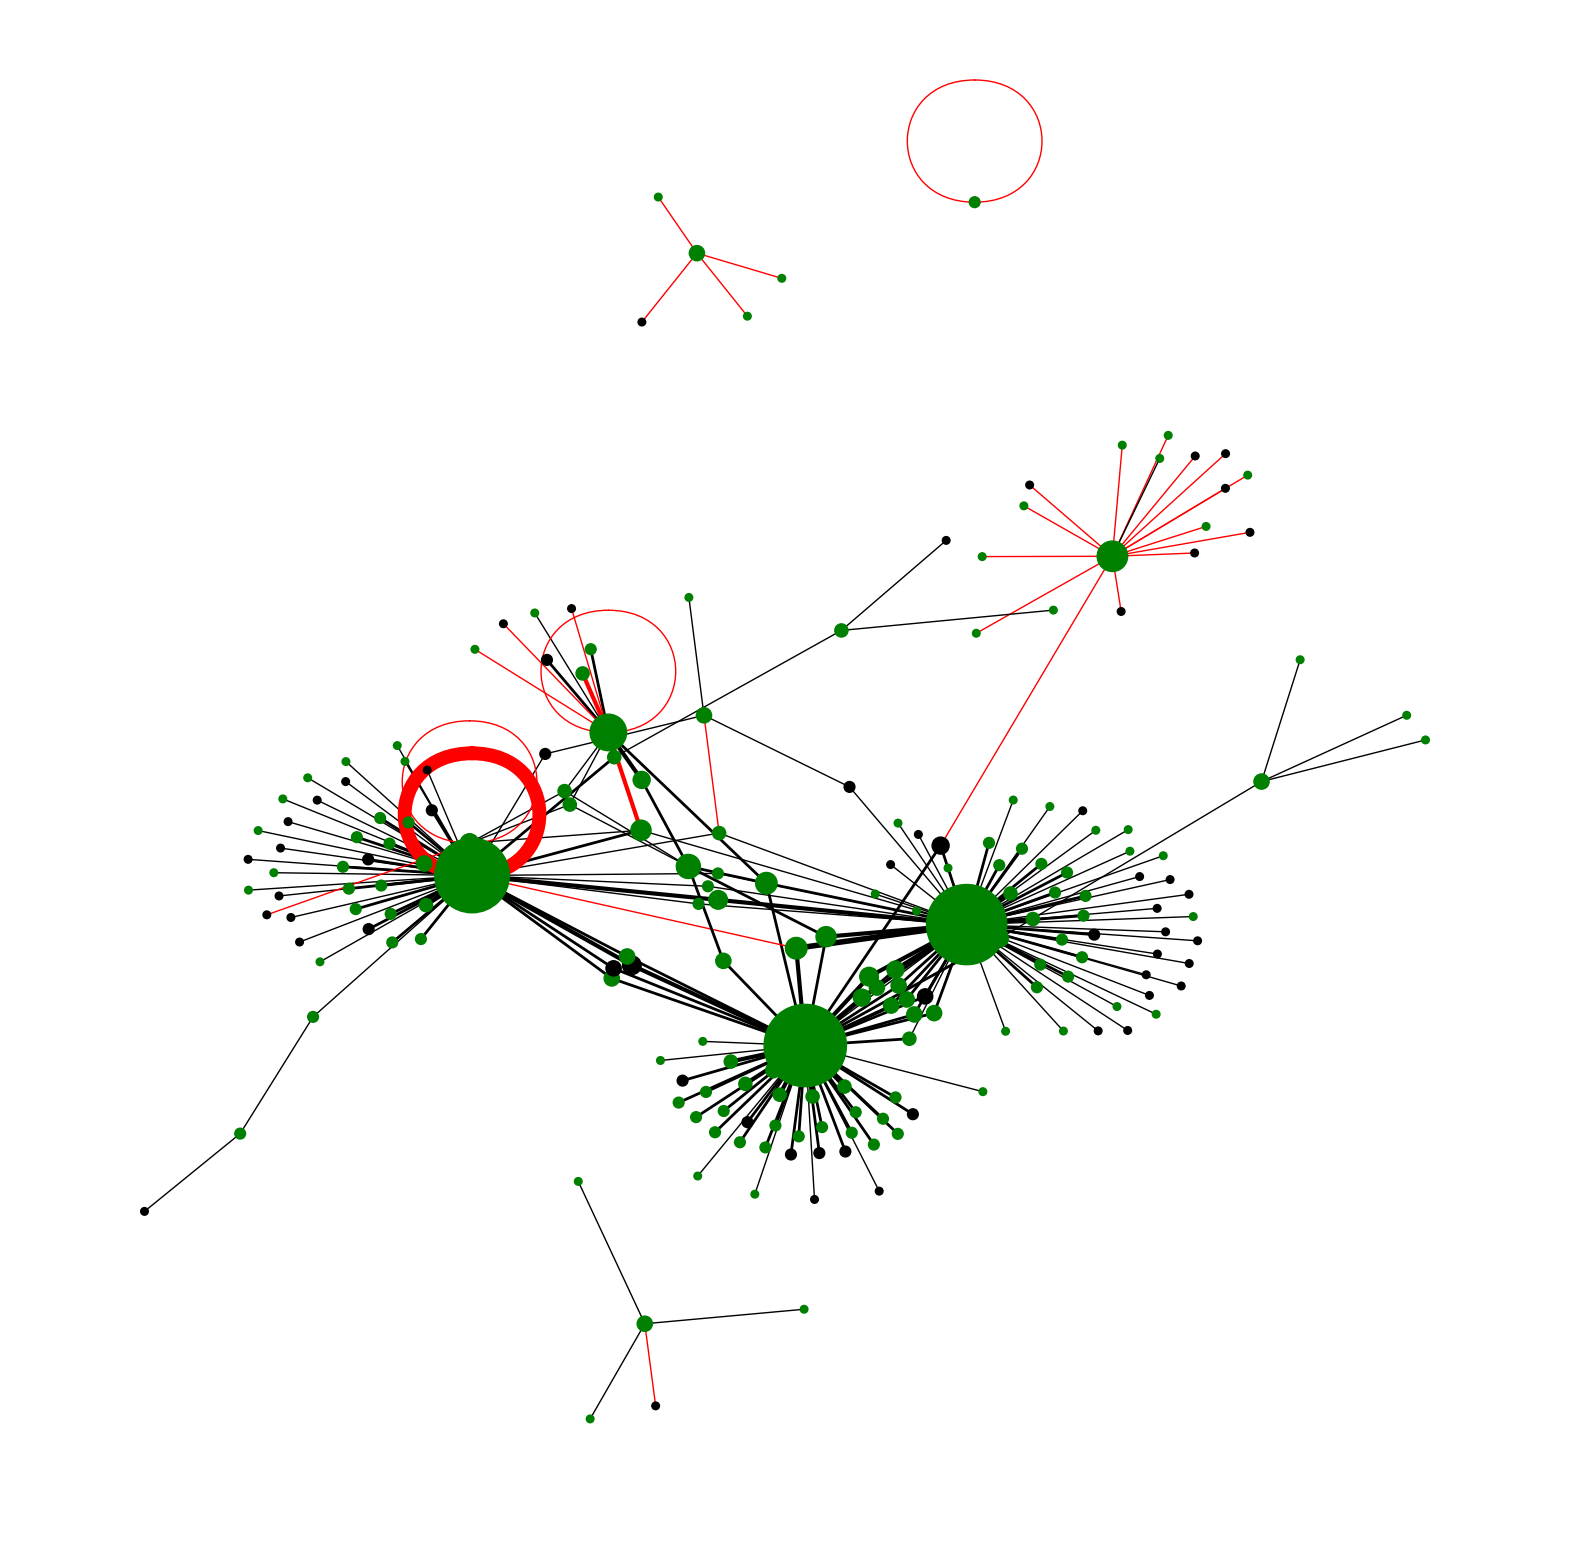

In [8]:
G = nx.Graph()

fig, ax = plt.subplots(figsize=(20, 20))
dict_part = {}
for i in range(len(data[0])):
    prot1 = data[0][i]
    prot2 = data[1][i]
    phys = data[2][i]
    if not prot1 in dict_part.keys():
        dict_part[prot1]={}
    if not prot2 in dict_part.keys():
        dict_part[prot2]={}
    if not prot2 in dict_part[prot1].keys():
        dict_part[prot1][prot2]=1
    else:
        dict_part[prot1][prot2]+=1
    if not prot1 in dict_part[prot2].keys():
        dict_part[prot2][prot1]=1
    else:
        dict_part[prot2][prot1]+=1
        
    if G.has_edge(prot1, prot2):
        G[prot1][prot2]['weight']+=1
    else:
        G.add_edge(prot1, prot2, weight=1, color='black')
    if phys:
        G[prot1][prot2]['color']='red'
list_size=[]
node_colors=[]
for elem in G.nodes.keys():
    list_size.append(sum(dict_part[elem].values())*30)
    if elem in liste_name:
        node_colors.append('green')
    else:
        node_colors.append('black')
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]    

pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=False, node_size=list_size, width=weights, edge_color=colors, node_color=node_colors)

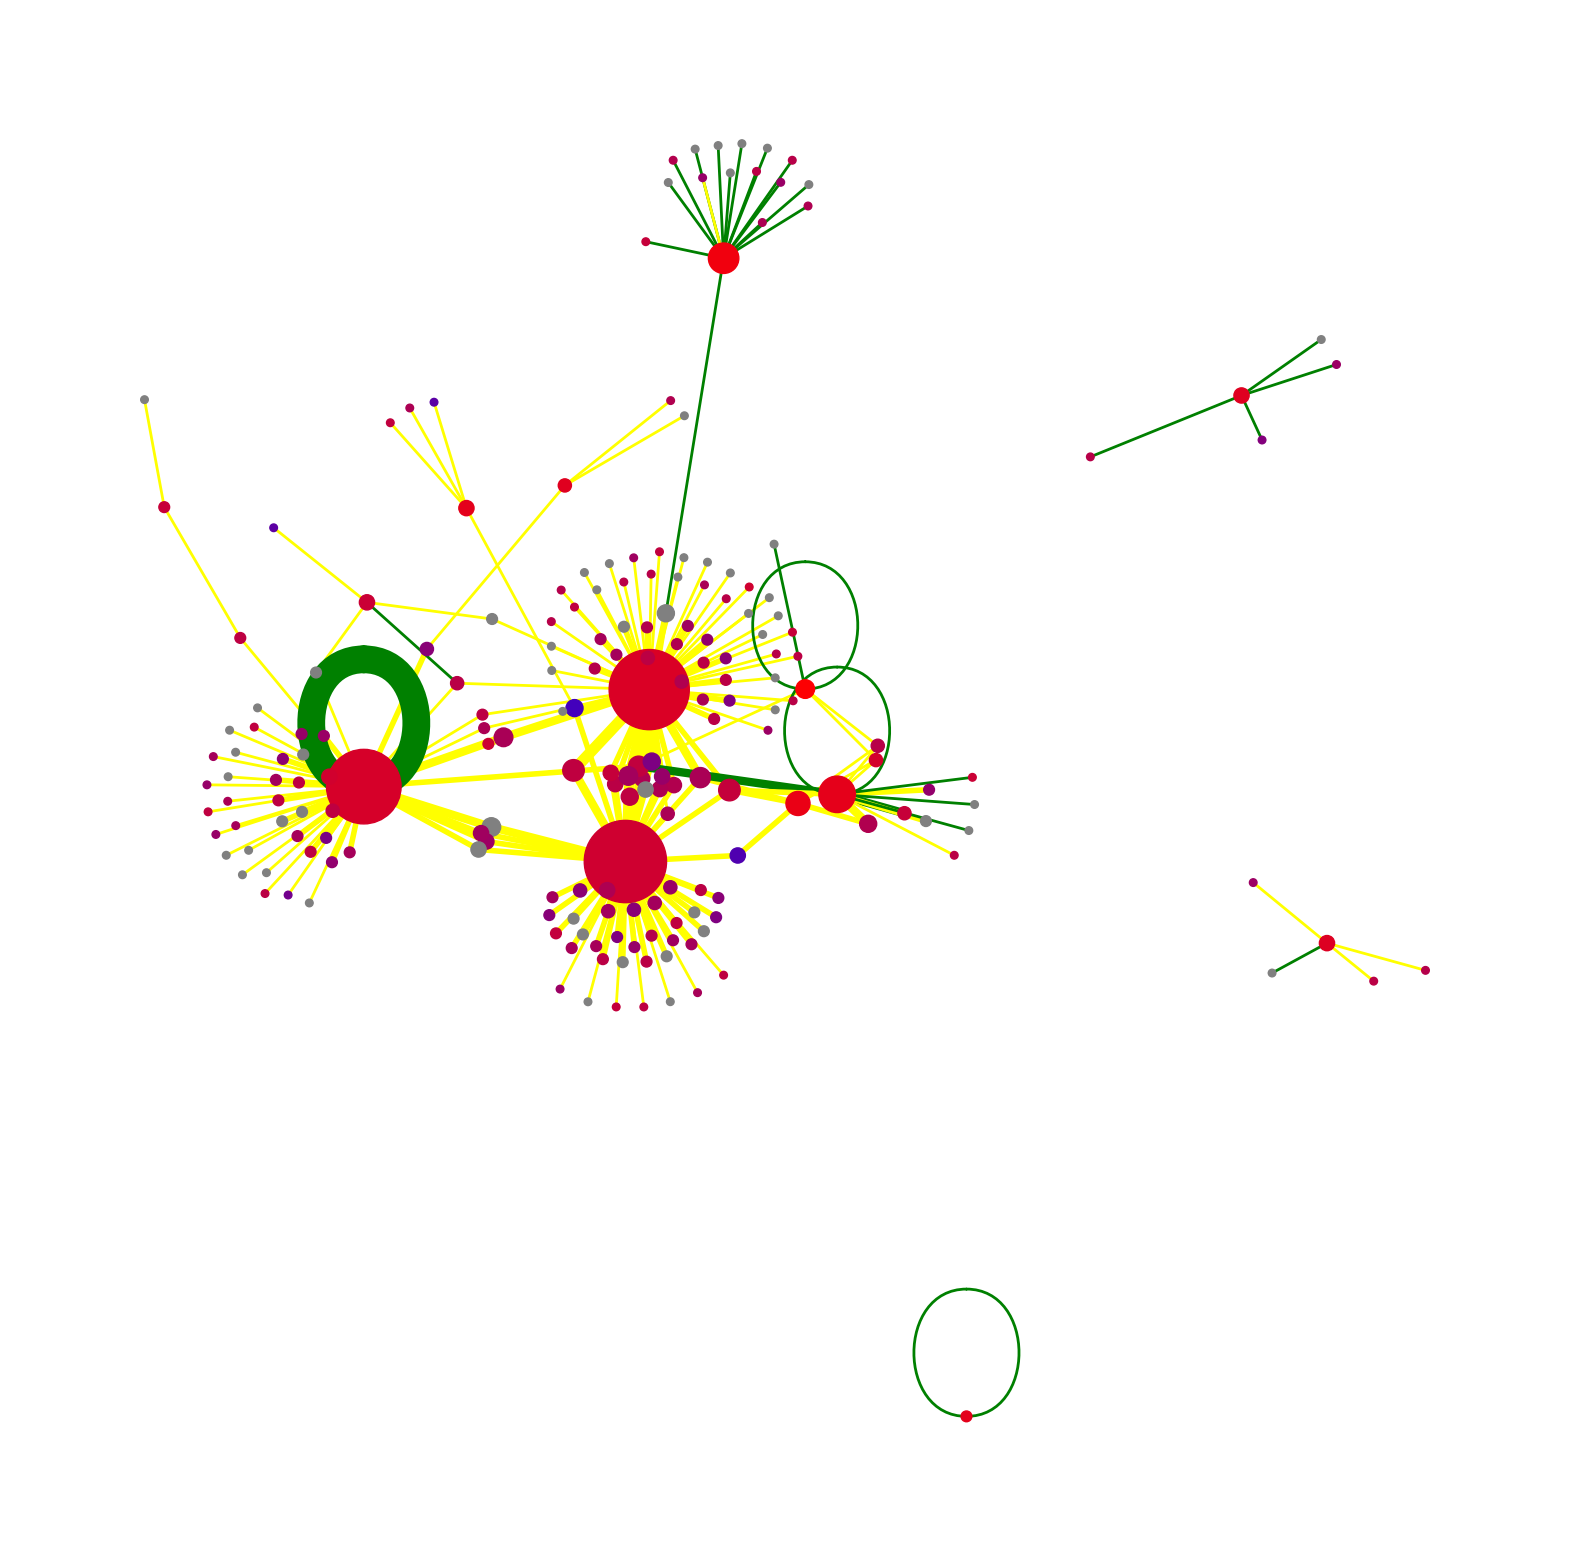

In [9]:


G = nx.Graph()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='blue'
c2='red'


fig, ax = plt.subplots(figsize=(20, 20))
dict_part = {}
for i in range(len(data[0])):
    prot1 = data[0][i]
    prot2 = data[1][i]
    phys = data[2][i]
    if not prot1 in dict_part.keys():
        dict_part[prot1]={}
    if not prot2 in dict_part.keys():
        dict_part[data[1][i]]={}
    if not prot2 in dict_part[prot1].keys():
        dict_part[prot1][prot2]=1
    else:
        dict_part[prot1][prot2]+=1
    if not prot1 in dict_part[prot2].keys():
        dict_part[prot2][prot1]=1
    else:
        dict_part[prot2][prot1]+=1
        
    if G.has_edge(prot1, prot2):
        G[prot1][prot2]['weight']+=2
    else:
        G.add_edge(prot1, prot2, weight=2, color='yellow')
    if phys:
        G[prot1][prot2]['color']='green'
list_size=[]
node_colors=[]
for elem in G.nodes.keys():
    list_size.append(sum(dict_part[elem].values())*30)
    if elem in liste_name:
        node_colors.append(colorFader(c1,c2,(liste_abund[liste_name.index(elem)]-min(liste_abund))/(max(liste_abund)-min(liste_abund))))
    else:
        node_colors.append('grey')
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]    

pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=False, node_size=list_size, width=weights, edge_color=colors, node_color=node_colors)

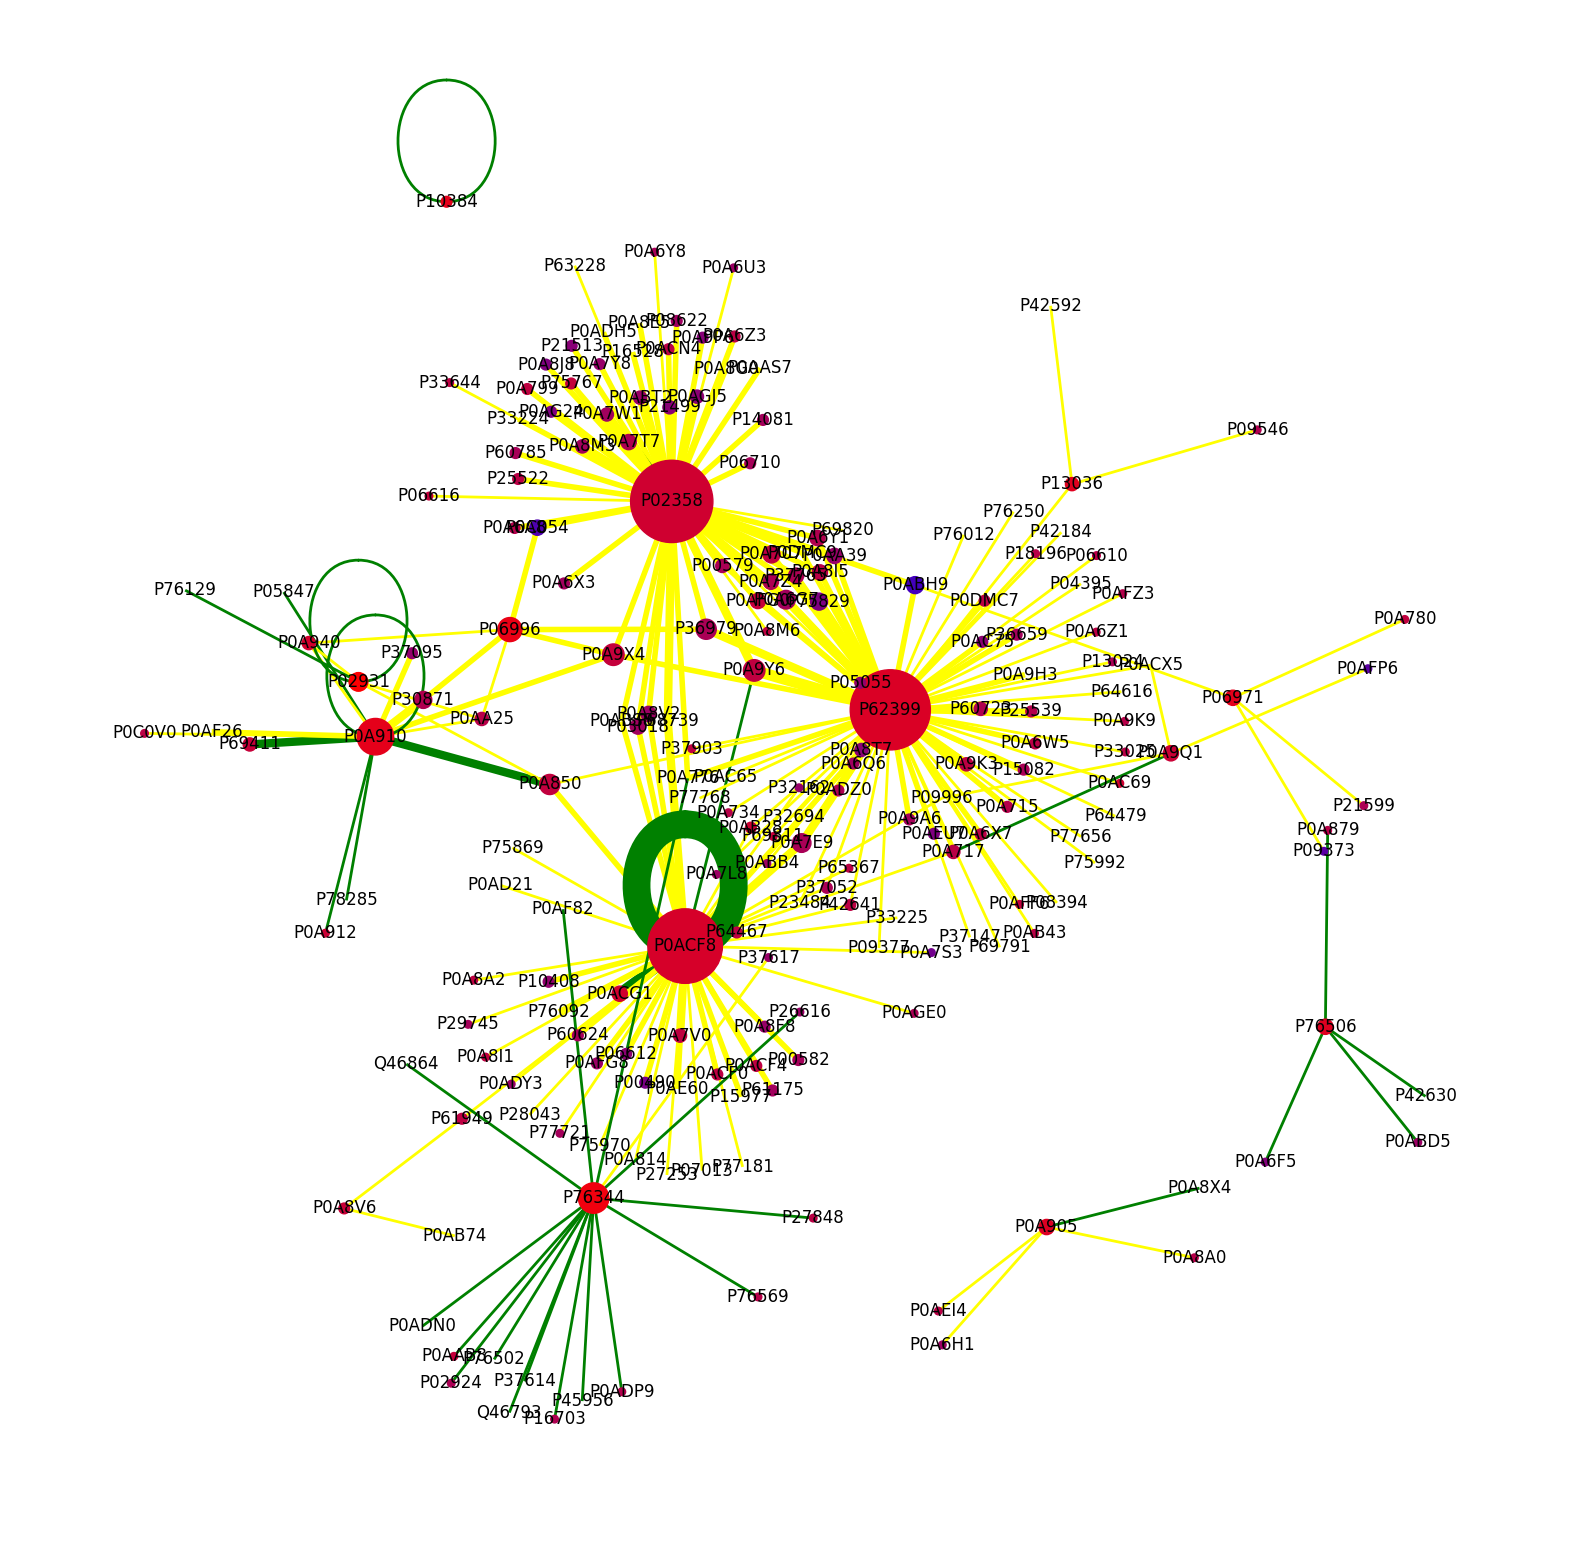

In [10]:
G = nx.Graph()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='blue'
c2='red'


fig, ax = plt.subplots(figsize=(20, 20))
dict_part = {}
for i in range(len(data[0])):
    prot1 = data[0][i]
    prot2 = data[1][i]
    phys = data[2][i]
    if not prot1 in dict_part.keys():
        dict_part[prot1]={}
    if not prot2 in dict_part.keys():
        dict_part[data[1][i]]={}
    if not prot2 in dict_part[prot1].keys():
        dict_part[prot1][prot2]=1
    else:
        dict_part[prot1][prot2]+=1
    if not prot1 in dict_part[prot2].keys():
        dict_part[prot2][prot1]=1
    else:
        dict_part[prot2][prot1]+=1
        
    if G.has_edge(prot1, prot2):
        G[prot1][prot2]['weight']+=2
    else:
        G.add_edge(prot1, prot2, weight=2, color='yellow')
    if phys:
        G[prot1][prot2]['color']='green'
list_size=[]
dict_colors={}
for elem in G.nodes.keys():
    if elem in liste_name:
        list_size.append(sum(dict_part[elem].values())*30)
    else:
        list_size.append(0)
    if elem in liste_name:
        dict_colors[elem] = colorFader(c1,c2,(liste_abund[liste_name.index(elem)]-min(liste_abund))/(max(liste_abund)-min(liste_abund)))
    else:
        dict_colors[elem] = 'grey'
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
nx.set_node_attributes(G, dict_colors, name="color")
node_colors = nx.get_node_attributes(G, "color")

pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=list_size, width=weights, edge_color=colors, node_color=node_colors.values())









In [11]:
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

names = dn.columns.tolist()
print(names)
d_filtered=dn.loc[dn[dn.columns[4]]>-0.0977520223573736][[names[index]for index in [0,4,6]]]

daccess = list(d_filtered['Accession'])
o = GO_ORA_analyser(f"{dataDir}/go.owl", f"{dataDir}/K12_proteome", f"{dataDir}/dataset")
all_go_term_scores=o.cellular_component(daccess)
print(all_go_term_scores)

class Rich_GO_ORA():
    def __init__(self, liste):
        self.liste = liste
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Description</td><td>GO</td><td>P-Value</td></tr></thead>"
        for elem in self.liste:
            htmlString += f"<tbody><tr><td>{elem[1]}</td><td>{elem[2]}</td><td>{elem[0]}</td></tr></tbody>"
        htmlString += "</table>"
        return htmlString
    
golist=Rich_GO_ORA(all_go_term_scores)

['Accession', 'Description', 'Gene Symbol', 'Corrected Abundance ratio (1.53)', 'Log2 Corrected Abundance Ratio', 'Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)', 'LOG10 Adj.P-val']
Loading ontology
Loaded
Reading whole proteome
4391 Loaded
reading experimental protein set
2024 Loaded
cellular component process GO Tree
Extracting cellular component ontology
Applying true path collapsing
61 GO terms, 128 leaves, 65 proteins
Extracting cellular component ontology
Applying true path collapsing
239 GO terms, 4698 leaves, 2805 proteins
Evaluated 60 / 60 Pathways, based on 67 proteins
[(6.89445722883255e-19, 'cell outer membrane', 'GO:0009279', ['P0A921', 'P0ADE4', 'P02943', 'P0A940', 'P09169', 'P05825', 'P0A915', 'P39180', 'P0A905', 'P76471', 'P76506', 'P13036', 'P0A927', 'P10384', 'P06971', 'P0A910', 'P0A908', 'P75780', 'P06996', 'P06129', 'P02930', 'P0A917', 'P02931', 'P0AB40', 'P0A921', 'P09169', 'P0A921', 'P0ADE4', 'P02943', 'P05825', 'P0A937', 'P06996', 'P0A903', 'P77774

In [12]:
i=0
indices = []
for go in all_go_term_scores:
    if len(go[3])>20:
        print(i, go[0], go[1], go[2], len(go[3]))
        indices.append(i)
    i+=1

dict_go_prot = {}
for go in all_go_term_scores:
    dict_go_prot[go[2]] = go[3]

f1=indices[0]
f2=indices[1]
f3=indices[2]
f4=indices[3]
f5=indices[4]
f6=indices[5]
f7=indices[6]
f8=indices[7]
f9=indices[8]
f10=indices[9]
f11=indices[10]
f12=indices[11]
f13=indices[12]
f14=indices[13]
f15=indices[14]
f16=indices[15]
f17=indices[16]


0 6.89445722883255e-19 cell outer membrane GO:0009279 36
1 6.89445722883255e-19 external encapsulating structure part GO:0044462 36
2 5.230046427944989e-18 outer membrane GO:0019867 37
3 6.234406512196581e-18 external encapsulating structure GO:0030312 36
4 4.1115666621131435e-14 cell envelope GO:0030313 40
11 0.00031473405628156437 protein-containing complex GO:0032991 25
25 0.016512905273448723 cell periphery GO:0071944 54
27 0.045959007390911646 membrane GO:0016020 86
37 0.1504399212237852 intrinsic component of membrane GO:0031224 44
40 0.21583634359830065 membrane part GO:0044425 46
41 0.25914993986125623 integral component of membrane GO:0016021 38
48 0.7348279157687075 cell part GO:0044464 92
50 0.8228974485738313 cytosol GO:0005829 24
51 0.8441790061985814 cytoplasmic part GO:0044444 25
56 0.977800174541715 cytoplasm GO:0005737 30
57 0.9791483518780836 intracellular part GO:0044424 31
59 1.0 cellular_component GO:0005575 128


lezgooooooooo


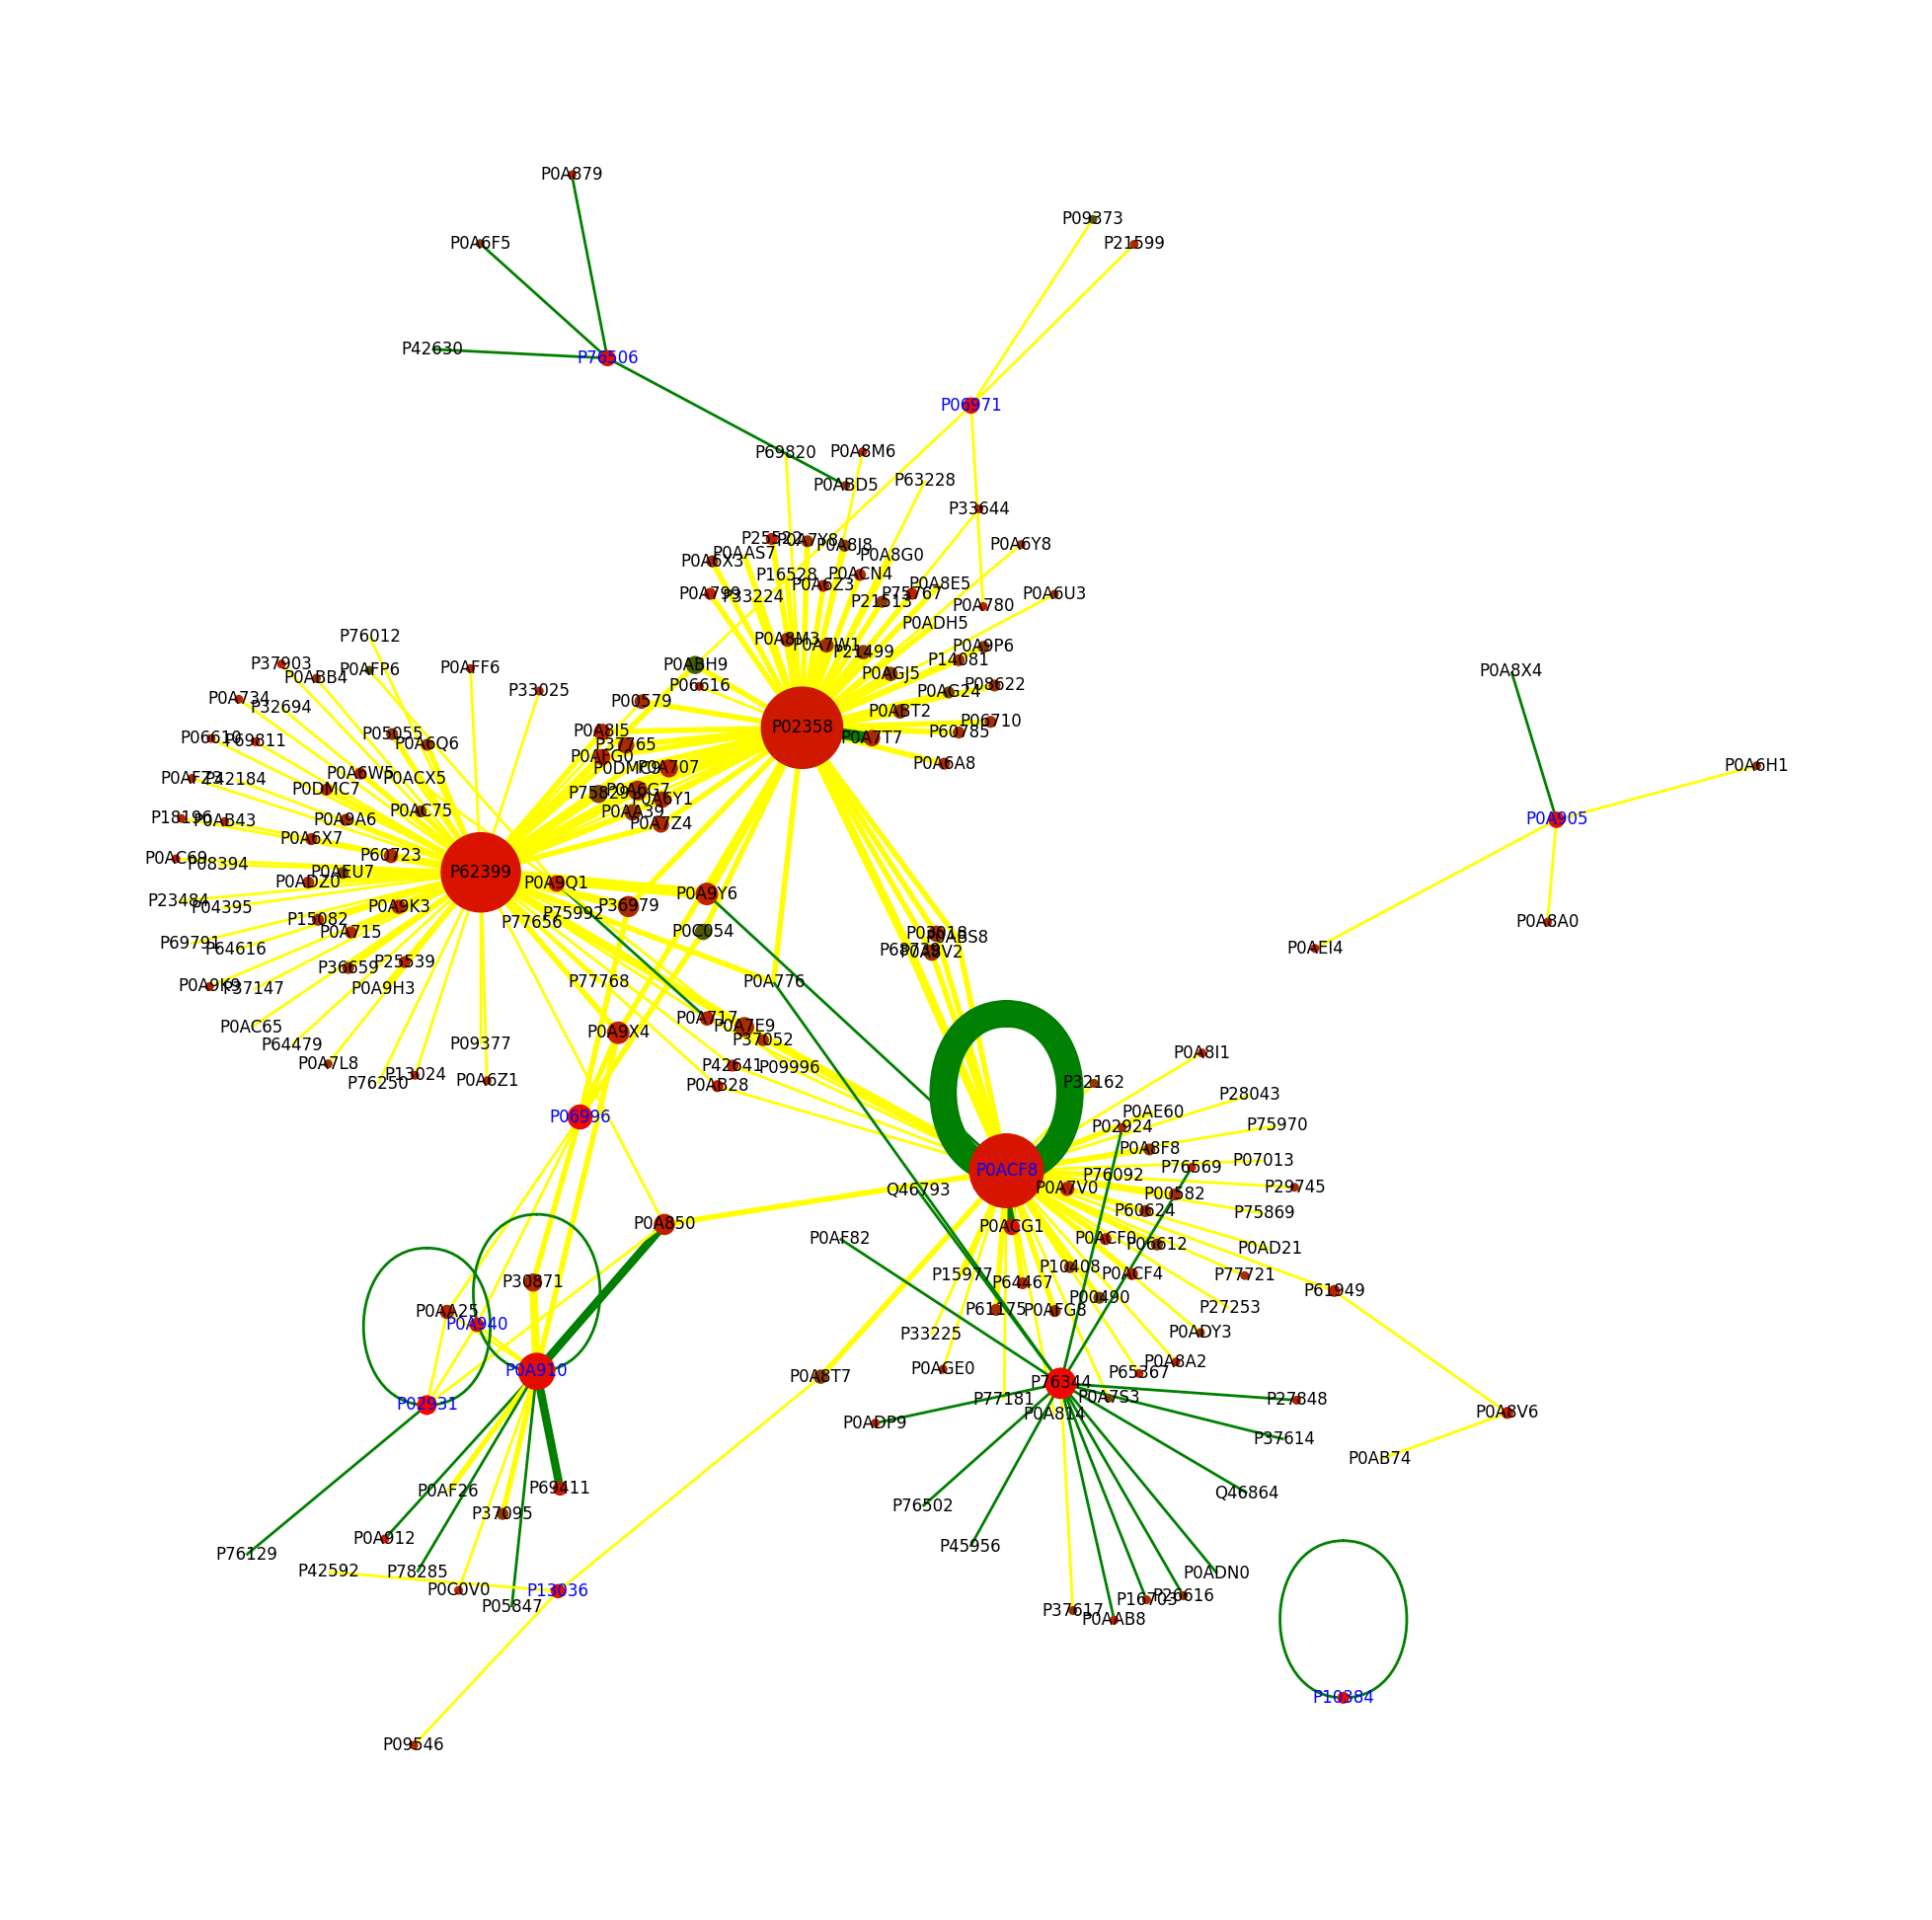

In [37]:
G = nx.Graph()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='green'
c2='red'


fig, ax = plt.subplots(figsize=(25, 25))
dict_part = {}
for i in range(len(data[0])):
    prot1 = data[0][i]
    prot2 = data[1][i]
    phys = data[2][i]
    if not prot1 in dict_part.keys():
        dict_part[prot1]={}
    if not prot2 in dict_part.keys():
        dict_part[data[1][i]]={}
    if not prot2 in dict_part[prot1].keys():
        dict_part[prot1][prot2]=1
    else:
        dict_part[prot1][prot2]+=1
    if not prot1 in dict_part[prot2].keys():
        dict_part[prot2][prot1]=1
    else:
        dict_part[prot2][prot1]+=1
        
    if G.has_edge(prot1, prot2):
        G[prot1][prot2]['weight']+=2
    else:
        G.add_edge(prot1, prot2, weight=2, color='yellow')
    if phys:
        G[prot1][prot2]['color']='green'
list_size=[]
dict_colors={}
for elem in G.nodes.keys():
    if elem in liste_name:
        list_size.append(sum(dict_part[elem].values())*30)
    else:
        list_size.append(0)
    if elem in liste_name:
        dict_colors[elem] = colorFader(c1,c2,(liste_abund[liste_name.index(elem)]-min(liste_abund))/(max(liste_abund)-min(liste_abund)))
    else:
        dict_colors[elem] = 'grey'
edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
nx.set_node_attributes(G, dict_colors, name="color")
node_colors = nx.get_node_attributes(G, "color")

pos = nx.spring_layout(G, k=0.25)

booliste = []
labels_GO = {}
labels_notGO = {}
go_term = 'GO:0016020'
for elem in d_filtered['Accession'].tolist():
    if elem in dict_go_prot[go_term]:
        booliste.append(elem)

for elem in G.nodes.keys():
    if elem in booliste:
        labels_GO[elem] = elem
    else:
        labels_notGO[elem] = elem


nx.draw(G, pos, with_labels=False, node_size=list_size, width=weights, edge_color=edge_colors, node_color=node_colors.values(), ax=ax)
nx.draw_networkx_labels(G, pos, labels_GO, font_color='blue')
nx.draw_networkx_labels(G, pos, labels_notGO, font_color='black')





####################
print('lezgooooooooo')
plt.savefig('foo.pdf')

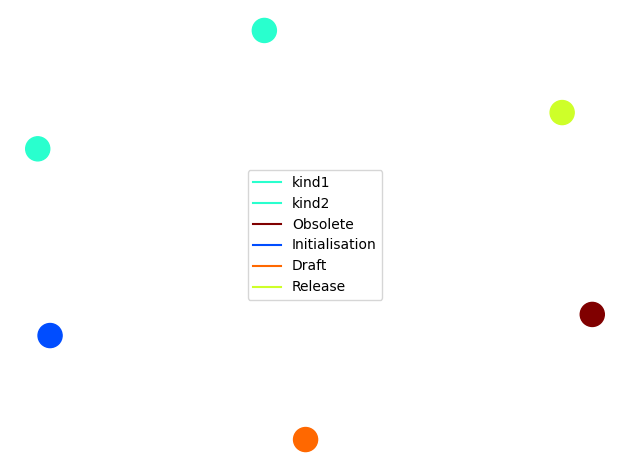

In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# For color mapping
import matplotlib.colors as colors
import matplotlib.cm as cmx

G=nx.Graph()
G.add_node("kind1")
G.add_node("kind2")
G.add_node("Obsolete")
G.add_node("Draft")
G.add_node("Release")
G.add_node("Initialisation")

# You were missing the position.
pos=nx.spring_layout(G)
val_map = {'kind1': 2, 
           'kind2': 2, 
           'Obsolete': 5, 
           'Initialisation': 1, 
           'Draft': 4, 
           'Release': 3}
values = [val_map.get(node, 0) for node in G.nodes()]
# Color mapping
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=max(values))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

# Using a figure to use it as a parameter when calling nx.draw_networkx
f = plt.figure(1)
ax = f.add_subplot(1,1,1)
for label in val_map:
    ax.plot([0],[0],
            color=scalarMap.to_rgba(val_map[label]),
            label=label)

# Just fixed the color map
nx.draw_networkx(G,pos, cmap=jet, vmin=0, vmax=max(values),
                 node_color=values,
                 with_labels=False, ax=ax)

# Here is were I get an error with your code                                                                                                                         
#nodes = nx.draw(G, cmap=plt.get_cmap('jet'), node_color=values)                                                                             

# Setting it to how it was looking before.                                                                                                              
plt.axis('off')
f.set_facecolor('w')

plt.legend(loc='center')

f.tight_layout()
plt.show()